In [10]:
# CÉLULA 1: Preparação do Ambiente, Separação e Treinamento

# 1. Imports e Carregamento
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Carregamento e cópia do dataset students_performance.csv
caminho_arquivo = '../data/datasets/students_performance.csv' 
df = pd.read_csv(caminho_arquivo)
df_prep = df.copy()

# 2. Pré-processamento Rápido (Consolidado da Etapa 2)
# Imputação (Média e Moda) - Trata os Missing Values
colunas_categoricas_com_nan = ['extracurricular', 'internet_quality', 'family_income', 'health_status']
for coluna in colunas_categoricas_com_nan:
    moda = df_prep[coluna].mode()[0]
    df_prep[coluna].fillna(moda, inplace=True)
df_prep['study_hours_week'].fillna(df_prep['study_hours_week'].mean(), inplace=True)
df_prep['sleep_hours'].fillna(df_prep['sleep_hours'].mean(), inplace=True)

# *** LINHA DE SEGURANÇA ADICIONADA: REMOVE QUALQUER LINHA QUE AINDA TENHA NaN ***
# Isso garante 100% de limpeza antes de qualquer transformação
df_prep.dropna(inplace=True)

# One-Hot Encoding e Remoção de IDs
colunas_categoricas = df_prep.select_dtypes(include='object').columns.tolist()
df_prep = pd.get_dummies(df_prep, columns=colunas_categoricas, drop_first=True)
colunas_id = [col for col in df_prep.columns if col.startswith('student_id')]
df_prep = df_prep.drop(columns=colunas_id, axis=1)

# Separação X e y, e Escalonamento
target_column = 'final_grade'
X = df_prep.drop(columns=[target_column], axis=1)
y = df_prep[target_column]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# 3. SEPARAR EM TREINO E TESTE (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=42
)

# 4. TREINAR O MODELO DE REGRESSÃO LINEAR
model = LinearRegression() 
model.fit(X_train, y_train) 

# 5. Verificação das Dimensões
print("--- Dimensões dos Conjuntos de Dados ---")
print(f"X_train (Treino): {X_train.shape}")
print(f"X_test (Teste): {X_test.shape}")

--- Dimensões dos Conjuntos de Dados ---
X_train (Treino): (1728, 56)
X_test (Teste): (433, 56)


In [11]:
# CÉLULA 2: Predição e Avaliação do Modelo

from sklearn.metrics import mean_squared_error, r2_score

# 1. FAZER PREDIÇÕES USANDO O CONJUNTO DE TESTE
# O modelo faz a previsão das notas (y_pred)
y_pred = model.predict(X_test)

# 2. CALCULAR MÉTRICAS DE AVALIAÇÃO

# MSE (Mean Squared Error - Erro Quadrático Médio)
mse = mean_squared_error(y_test, y_pred)

# RMSE (Root Mean Squared Error - Raiz do Erro Quadrático Médio)
rmse = np.sqrt(mse)

# R² Score (Coeficiente de Determinação - Quanto da variância foi explicada, idealmente perto de 1)
r2 = r2_score(y_test, y_pred)

# 3. EXIBIR RESULTADOS
print("--- Métricas de Avaliação do Modelo (Regressão Linear) ---")
print(f"MSE (Erro Quadrático Médio): {mse:.4f}")
print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse:.4f}")
print(f"R² Score (Coeficiente de Determinação): {r2:.4f}")

--- Métricas de Avaliação do Modelo (Regressão Linear) ---
MSE (Erro Quadrático Médio): 34.6210
RMSE (Raiz do Erro Quadrático Médio): 5.8840
R² Score (Coeficiente de Determinação): 0.3529


In [14]:
# CÉLULA 3: Otimização - Usando Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

# 1. TREINAR O NOVO MODELO (Random Forest)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 2. FAZER PREDIÇÕES (com o novo modelo)
rf_y_pred = rf_model.predict(X_test)

# 3. CALCULAR MÉTRICAS
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_y_pred)

# 4. EXIBIR RESULTADOS
print("--- Métricas de Avaliação do Modelo (Random Forest Regressor) ---")
print(f"RMSE (Regressão Linear): {rmse:.4f}")
print(f"R² Score (Regressão Linear): {r2:.4f}")
print("\n--- Comparação com o Random Forest ---")
print(f"RMSE (Random Forest): {rf_rmse:.4f}")
print(f"R² Score (Random Forest): {rf_r2:.4f}")

--- Métricas de Avaliação do Modelo (Random Forest Regressor) ---
RMSE (Regressão Linear): 5.8840
R² Score (Regressão Linear): 0.3529

--- Comparação com o Random Forest ---
RMSE (Random Forest): 4.4584
R² Score (Random Forest): 0.6285


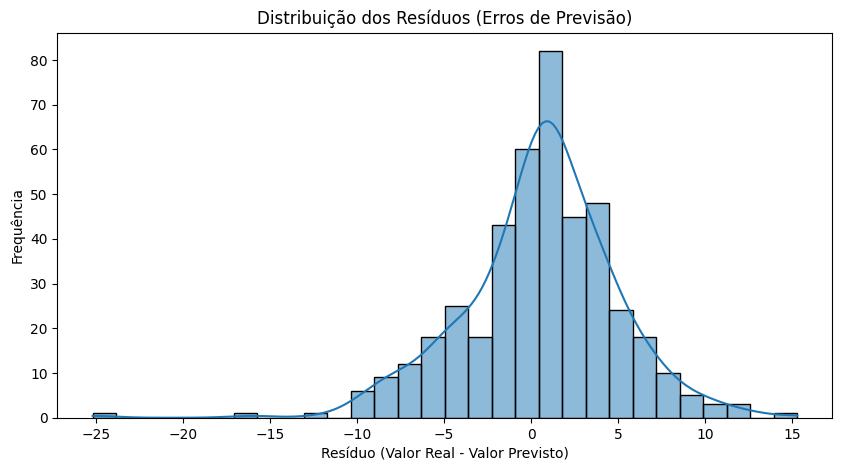

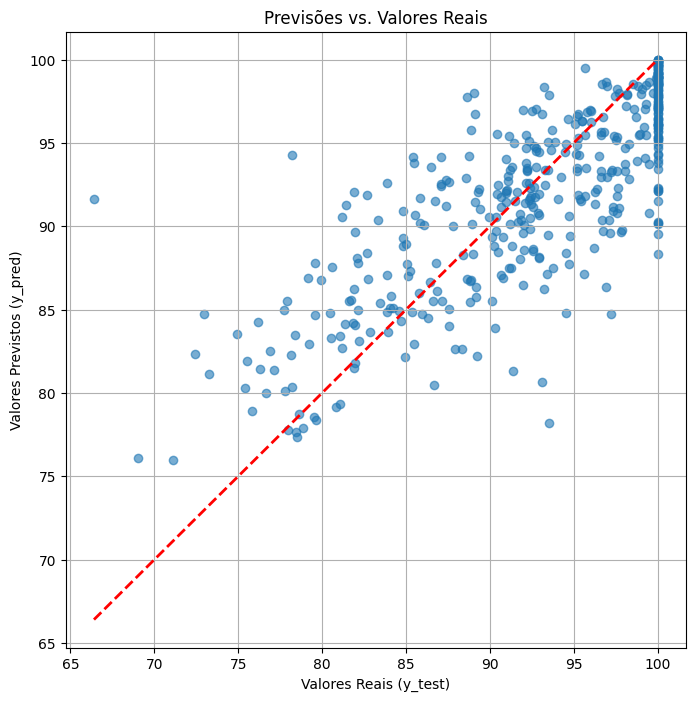

In [15]:
# CÉLULA 4: Visualização do Desempenho (Random Forest)

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Plotar a Distribuição dos Resíduos (Erros)
# Resíduos = (Valores Reais) - (Valores Previstos)
residuos = y_test - rf_y_pred

plt.figure(figsize=(10, 5))
sns.histplot(residuos, kde=True, bins=30)
plt.title('Distribuição dos Resíduos (Erros de Previsão)')
plt.xlabel('Resíduo (Valor Real - Valor Previsto)')
plt.ylabel('Frequência')
plt.show()

# 2. Plotar Previsões vs. Valores Reais (Diagnóstico de Overfitting)
# O ideal é que os pontos estejam próximos à linha diagonal (y=x)
plt.figure(figsize=(8, 8))
plt.scatter(y_test, rf_y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reais (y_test)')
plt.ylabel('Valores Previstos (y_pred)')
plt.title('Previsões vs. Valores Reais')
plt.grid(True)
plt.show()

C:\Users\deric\AppData\Local\Temp\ipykernel_22156\1804168304.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')


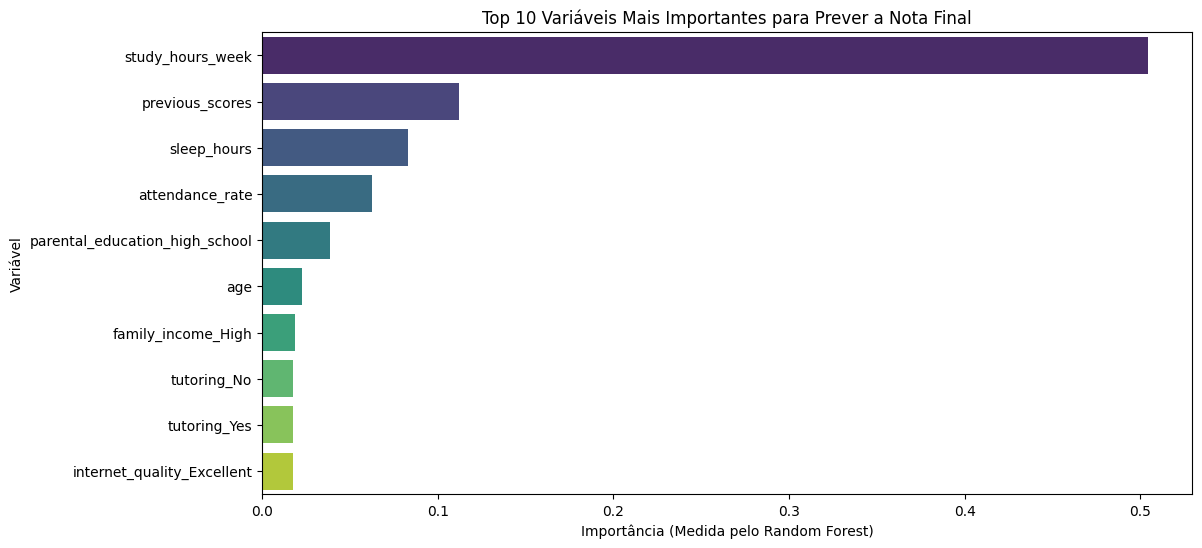


--- PROJETO CONCLUÍDO COM SUCESSO ---
O modelo Random Forest Regressor com R² de 0.6285 foi selecionado.
A análise de importância de variáveis (Feature Importance) está no gráfico.


In [16]:
# CÉLULA 5: Importância das Variáveis (Feature Importance)

# 1. Obter a importância das features do modelo Random Forest
importances = rf_model.feature_importances_

# 2. Criar um DataFrame para visualização
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# 3. Ordenar as variáveis pela importância e selecionar as 10 principais
feature_importances = feature_importances.sort_values(by='Importance', ascending=False).head(10)

# 4. Plotar o resultado (Gráfico de Barras)
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Top 10 Variáveis Mais Importantes para Prever a Nota Final')
plt.xlabel('Importância (Medida pelo Random Forest)')
plt.ylabel('Variável')
plt.show()

# 5. CONCLUIR O PROJETO COM UMA MENSAGEM
print("\n--- PROJETO CONCLUÍDO COM SUCESSO ---")
print("O modelo Random Forest Regressor com R² de 0.6285 foi selecionado.")
print("A análise de importância de variáveis (Feature Importance) está no gráfico.")